In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

pd.set_option('display.max_columns', None)

In [65]:
df = pd.read_csv('outliers_treated.csv')

In [66]:
df = df.drop(columns=['society','price_per_sqft','Unnamed: 0'],axis=1)

In [67]:
df.head()

,property_type,sector,price,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score,outliers,area_room_ratio
0,flat,sector 36,0.82,1081.0,Super Built up area 1081(100.43 sq.m.)Carpet a...,3,2,2,2.0,NaN,New Property,1081.0,NaN,650.0,0,0,0,0,0,0,8,1,360.333333
1,flat,sector 89,0.95,1105.0,Carpet area: 1103 (102.47 sq.m.),2,2,2,4.0,NaN,New Property,NaN,NaN,1103.0,1,1,0,0,0,0,38,1,552.500000
2,flat,sohna road,0.32,585.0,Built Up area: 1000 (92.9 sq.m.)Carpet area: 5...,2,2,1,17.0,NaN,New Property,NaN,1000.0,585.0,0,0,0,0,0,0,49,1,292.500000
3,flat,sector 92,1.60,1995.0,Super Built up area 1995(185.34 sq.m.)Built Up...,3,4,3+,10.0,North-West,Relatively New,1995.0,1615.0,1476.0,0,1,0,0,1,1,174,-1,665.000000
4,flat,sector 102,0.48,532.0,Super Built up area 632(58.71 sq.m.)Carpet are...,2,2,1,5.0,North-East,Relatively New,632.0,NaN,532.0,0,0,1,0,0,0,159,-1,266.000000


# Binning the luxary_score column

<Axes: xlabel='luxury_score'>

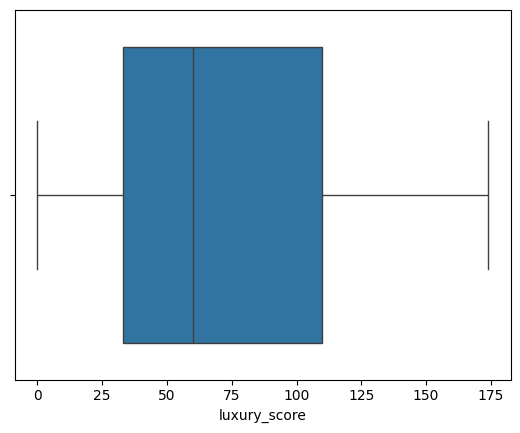

In [68]:
sns.boxplot(x=df['luxury_score'])

In [69]:
df['luxury_score'].describe()

count    3649.000000
mean       72.071800
std        52.883881
min         0.000000
25%        33.000000
50%        60.000000
75%       110.000000
max       174.000000
Name: luxury_score, dtype: float64

In [70]:
df['luxury_category'] = pd.cut(df['luxury_score'],bins=[-1,50,150,175],labels=['low','medium','high'])

**To include the value 0 , we have to start our binning from -1**

# Binning floorNum column

<Axes: xlabel='floorNum'>

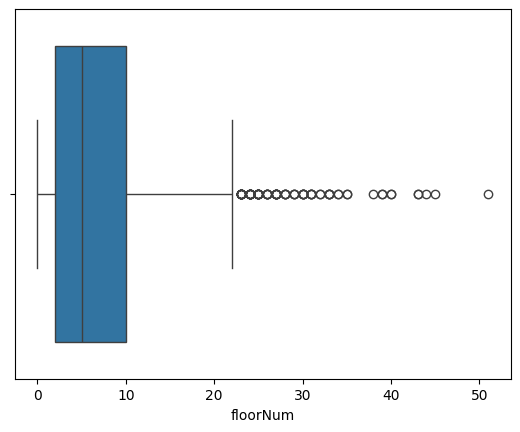

In [71]:
sns.boxplot(x=df['floorNum'])

In [72]:
df['floorNum'].describe()

count    3632.000000
mean        6.937775
std         6.089255
min         0.000000
25%         2.000000
50%         5.000000
75%        10.000000
max        51.000000
Name: floorNum, dtype: float64

In [73]:
df['floorNum_cat'] = pd.cut(df['floorNum'],bins=[-1,3,10,51],labels=['low','medium','high'])

In [74]:
df.drop(columns=['luxury_score','floorNum','outliers','area_room_ratio','facing','area'],axis=1,inplace=True)

In [75]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Ordinal Encoding After Imputing missing values
## first we will change the original df , then we will extract x and y.
## Because we need to perform Correlation analysis which needs price column

In [76]:
df.loc[df['agePossession'] == 'Undefined','agePossession'] = np.nan

In [77]:
df.isnull().sum()

property_type             0
sector                    0
price                     0
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
agePossession           315
super_built_up_area    1735
built_up_area          2042
carpet_area            1752
study room                0
servant room              0
store room                0
pooja room                0
others                    0
furnishing_type           0
luxury_category           0
floorNum_cat             17
dtype: int64

In [78]:
df[['agePossession','floorNum_cat']] = SimpleImputer(strategy='most_frequent').fit_transform(df[['agePossession','floorNum_cat']])

In [79]:
df[['super_built_up_area','built_up_area','carpet_area']] = SimpleImputer(strategy='median').fit_transform(df[['super_built_up_area','built_up_area','carpet_area']])

In [80]:
df.isnull().sum()

property_type          0
sector                 0
price                  0
areaWithType           0
bedRoom                0
bathroom               0
balcony                0
agePossession          0
super_built_up_area    0
built_up_area          0
carpet_area            0
study room             0
servant room           0
store room             0
pooja room             0
others                 0
furnishing_type        0
luxury_category        0
floorNum_cat           0
dtype: int64

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3649 entries, 0 to 3648
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   property_type        3649 non-null   object  
 1   sector               3649 non-null   object  
 2   price                3649 non-null   float64 
 3   areaWithType         3649 non-null   object  
 4   bedRoom              3649 non-null   int64   
 5   bathroom             3649 non-null   int64   
 6   balcony              3649 non-null   object  
 7   agePossession        3649 non-null   object  
 8   super_built_up_area  3649 non-null   float64 
 9   built_up_area        3649 non-null   float64 
 10  carpet_area          3649 non-null   float64 
 11  study room           3649 non-null   int64   
 12  servant room         3649 non-null   int64   
 13  store room           3649 non-null   int64   
 14  pooja room           3649 non-null   int64   
 15  others               

# Without pipeline to get a full dataframe to perform feature selection 

In [82]:
cat_cols = df.select_dtypes(include=['object','category']).columns

In [83]:
for col in cat_cols:
    df[col] = OrdinalEncoder().fit_transform(df[[col]])

In [84]:
df.head()

,property_type,sector,price,areaWithType,bedRoom,bathroom,balcony,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_category,floorNum_cat
0,0.0,36.0,0.82,1031.0,3,2,2.0,1.0,1081.00,1650.0,650.0,0,0,0,0,0,0,1.0,1.0
1,0.0,95.0,0.95,361.0,2,2,2.0,1.0,1827.75,1650.0,1103.0,1,1,0,0,0,0,1.0,2.0
2,0.0,103.0,0.32,2.0,2,2,1.0,1.0,1827.75,1000.0,585.0,0,0,0,0,0,0,1.0,0.0
3,0.0,99.0,1.60,1666.0,3,4,4.0,3.0,1995.00,1615.0,1476.0,0,1,0,0,1,1,0.0,2.0
4,0.0,5.0,0.48,2215.0,2,2,1.0,3.0,632.00,1650.0,532.0,0,0,1,0,0,0,0.0,2.0


# With Pipeline , not using this (Will use in the final model)

In [85]:
# imputer_pipe = Pipeline([
#     ('Simple Imputer',SimpleImputer(strategy='most_frequent')),
#     ('Ordinal',OrdinalEncoder())
#     ])

# ct = ColumnTransformer(transformers=[
#     ('agePossession_Imputing', imputer_pipe, ['agePossession','floorNum_cat']),
#     ('ordinal', OrdinalEncoder(), ['luxury_category','property_type','sector'])
# ], remainder='passthrough')
# x = ct.fit_transform(x)


In [86]:
x = df.drop(columns=['price'],axis=1)
y =df['price']

### Always scale the data 

In [87]:
from sklearn.preprocessing import StandardScaler
x_scaled = StandardScaler().fit_transform(x)

# (1) Correlation 

<Axes: >

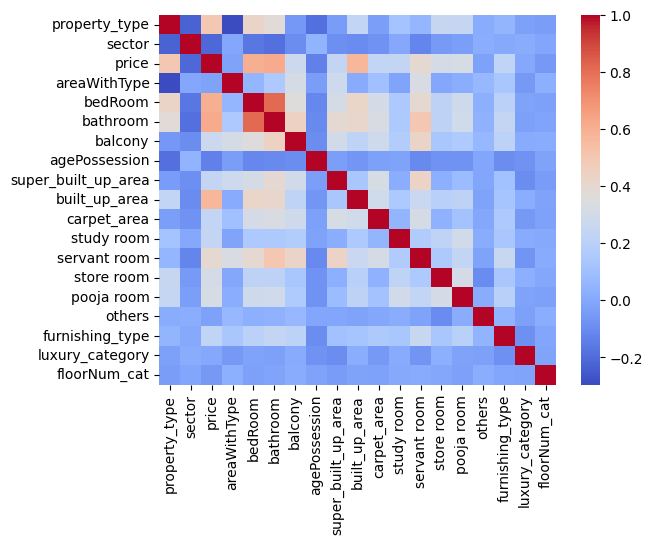

In [88]:
sns.heatmap(df.corr(),cmap='coolwarm')

In [89]:
fi_df1 = df.corr()['price'].to_frame().reset_index().rename(columns={'index':'features','price':'corr'}).sort_values('corr', ascending=False)

In [90]:
fi_df1

,features,corr
2,price,1.000000
5,bathroom,0.617386
4,bedRoom,0.603839
9,built_up_area,0.570872
0,property_type,0.502843
12,servant room,0.393250
14,pooja room,0.317395
13,store room,0.308297
6,balcony,0.269440
8,super_built_up_area,0.240390


In [91]:
# lowest 5 columns are ( close to 0):
fi_df1.tail(5)

,features,corr
3,areaWithType,-0.016954
15,others,-0.023534
18,floorNum_cat,-0.052371
7,agePossession,-0.137359
1,sector,-0.212087


# (2) RF feature Importance

In [92]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100,random_state=0)
rf.fit(x_scaled,y)

fi_df2 = pd.DataFrame({'features':x.columns,'rf_Importance':rf.feature_importances_}).sort_values('rf_Importance',ascending=False)
fi_df2

,features,rf_Importance
8,built_up_area,0.480702
3,bedRoom,0.097767
1,sector,0.090309
2,areaWithType,0.086624
4,bathroom,0.082650
9,carpet_area,0.032018
0,property_type,0.025728
7,super_built_up_area,0.021279
11,servant room,0.016776
6,agePossession,0.013692


In [93]:
## lowest 5:
fi_df2.tail(5)


,features,rf_Importance
17,floorNum_cat,0.006229
16,luxury_category,0.005881
12,store room,0.005061
13,pooja room,0.004797
14,others,0.001956


# (3) Gradient Boosting

In [94]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=100,random_state=0).fit(x_scaled,y)

fi_df3 = pd.DataFrame({'features':x.columns,'GB_Importance':gb.feature_importances_}).sort_values('GB_Importance',ascending=False)
fi_df3

,features,GB_Importance
8,built_up_area,0.466980
3,bedRoom,0.126156
1,sector,0.122066
4,bathroom,0.086050
0,property_type,0.055895
11,servant room,0.049855
2,areaWithType,0.029896
7,super_built_up_area,0.023986
9,carpet_area,0.022749
10,study room,0.004583


In [95]:
# lowest 5:
fi_df3.tail(5)


,features,GB_Importance
6,agePossession,0.001576
17,floorNum_cat,0.000632
16,luxury_category,0.000598
13,pooja room,0.000589
14,others,0.000413


# (4) Recursive Feature Elimination (RFE)
## - Backward Subset Selection (mlxtend)    
###  -  Use when small (0-20 columns) 

In [96]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=0),
          n_features_to_select=x.shape[1]).fit(x_scaled,y)

features = x.columns[rfe.support_]
importance = rfe.estimator_.feature_importances_

fi_df4 = pd.DataFrame({'features':features,'RFE_Importance':importance}).sort_values('RFE_Importance',ascending=False)
fi_df4

,features,RFE_Importance
8,built_up_area,0.480702
3,bedRoom,0.097767
1,sector,0.090309
2,areaWithType,0.086624
4,bathroom,0.082650
9,carpet_area,0.032018
0,property_type,0.025728
7,super_built_up_area,0.021279
11,servant room,0.016776
6,agePossession,0.013692


In [97]:
## lowest 5:
fi_df4.tail()

,features,RFE_Importance
17,floorNum_cat,0.006229
16,luxury_category,0.005881
12,store room,0.005061
13,pooja room,0.004797
14,others,0.001956


# (5) Lasso
## - Great for linear Assumptions 
###  - Ordinal Encoding distorts linear models/relations , so be careful 

In [98]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1).fit(x_scaled,y)

fi_df5 = pd.DataFrame({'features':x.columns,'lasso_Importance': lasso.coef_}).sort_values('lasso_Importance',ascending=False)
fi_df5

,features,lasso_Importance
8,built_up_area,0.812143
0,property_type,0.658378
4,bathroom,0.526906
3,bedRoom,0.279813
11,servant room,0.238752
12,store room,0.145310
10,study room,0.132709
15,furnishing_type,0.084210
7,super_built_up_area,0.045845
13,pooja room,0.025645


In [99]:
# lowest 

fi_df5[fi_df5['lasso_Importance'] == 0]

,features,lasso_Importance
9,carpet_area,0.0
6,agePossession,-0.0
2,areaWithType,-0.0
5,balcony,0.0
16,luxury_category,0.0
14,others,-0.0
17,floorNum_cat,-0.0


# (6) Permutation Importance
## - Sensitive to Data Leakage ( have to split training and test data)

In [100]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x_scaled,y,test_size=0.2,random_state=0)

rf = RandomForestRegressor(n_estimators=100,random_state=0)
rf.fit(x_train,y_train)

Pi = permutation_importance(estimator=rf,X=x_test,y=y_test,scoring='neg_mean_squared_error',n_repeats=10,random_state=0)

fi_df6 = pd.DataFrame({'features':x.columns,'pi_importance':Pi.importances_mean}).sort_values('pi_importance',ascending=False)
fi_df6

,features,pi_importance
8,built_up_area,1.909686
4,bathroom,0.828465
1,sector,0.766496
3,bedRoom,0.500197
2,areaWithType,0.466657
0,property_type,0.359531
9,carpet_area,0.238011
11,servant room,0.204924
7,super_built_up_area,0.192301
17,floorNum_cat,0.030170


## lowest 5:
16	luxury_category	0.007134  
15	furnishing_type	0.005356  
14	others	0.003336  
13	pooja room	-0.002289  
12	store room	-0.012513  


 # (7) Shap (Game Theory)
## - Have to use different training and test data

In [101]:
rf = RandomForestRegressor(n_estimators=100,random_state=0)
rf.fit(x_train,y_train)

RandomForestRegressor(random_state=0)

In [102]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer(x_test,check_additivity=False)

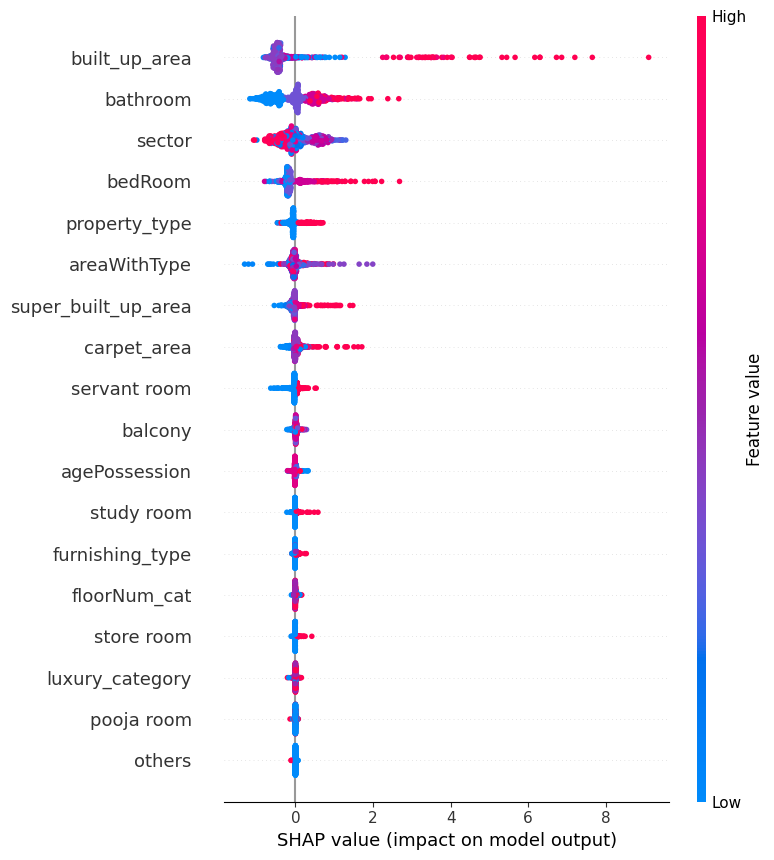

In [103]:
shap.summary_plot(shap_values=shap_values,features=x_test,feature_names=x.columns)

In [104]:
fi_df7 = pd.DataFrame({'features':x.columns,'shap_importance':np.abs(shap_values.values).mean(axis=0)}).sort_values('shap_importance',ascending=False)
fi_df7

,features,shap_importance
8,built_up_area,0.709660
4,bathroom,0.474778
1,sector,0.338410
3,bedRoom,0.273084
0,property_type,0.129724
2,areaWithType,0.119725
7,super_built_up_area,0.100009
9,carpet_area,0.089863
11,servant room,0.063359
5,balcony,0.030358


In [105]:
## Lowest 5:
fi_df7.tail(5)

,features,shap_importance
17,floorNum_cat,0.014563
12,store room,0.013715
16,luxury_category,0.012278
13,pooja room,0.004894
14,others,0.004523


## Merging all the df based on features 

In [106]:
final_df = fi_df1.merge(fi_df2,on='features').merge(fi_df3,on='features').merge(fi_df4,on='features').merge(fi_df5,on='features').merge(fi_df6,on='features').merge(fi_df7,on='features').set_index('features')

In [107]:
final_df

,corr,rf_Importance,GB_Importance,RFE_Importance,lasso_Importance,pi_importance,shap_importance
features,,,,,,,
bathroom,0.617386,0.082650,0.086050,0.082650,0.526906,0.828465,0.474778
bedRoom,0.603839,0.097767,0.126156,0.097767,0.279813,0.500197,0.273084
built_up_area,0.570872,0.480702,0.466980,0.480702,0.812143,1.909686,0.709660
property_type,0.502843,0.025728,0.055895,0.025728,0.658378,0.359531,0.129724
servant room,0.393250,0.016776,0.049855,0.016776,0.238752,0.204924,0.063359
pooja room,0.317395,0.004797,0.000589,0.004797,0.025645,-0.002289,0.004894
store room,0.308297,0.005061,0.001836,0.005061,0.145310,-0.012513,0.013715
balcony,0.269440,0.011136,0.004337,0.011136,0.000000,0.021076,0.030358
super_built_up_area,0.240390,0.021279,0.023986,0.021279,0.045845,0.192301,0.100009


## Normalizing the Df by dividing each column with it's total column-wise sum
### - axis=0 for vertical operations (Column wise sum of each features)
### - axis=1 for Horizontal Operations (Divide each column by it's total sum)

In [108]:
final_df = final_df.divide(final_df.sum(axis=0),axis=1)

### Lasso and Corr is not reliable here because 
### we have performed Ordinal Encoding which distorts Linear relations/Models

In [109]:
final_df = final_df[[ 'rf_Importance', 'GB_Importance', 'RFE_Importance','pi_importance','shap_importance']].mean(axis=1).sort_values(ascending=False)

## Let's remove the last 5 columns and check the before and after cross val score 

In [110]:
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(n_estimators=100,random_state=0)

cv1 = cross_val_score(estimator=rf,X=x,y=y,scoring='neg_mean_squared_error',cv=5)

cv1.mean()

np.float64(-1.487214809948735)

In [114]:
cv2 = cross_val_score(estimator=rf,X=x.drop(columns=['store room','pooja room','others','luxury_category','floorNum_cat']),y=y,scoring='neg_mean_squared_error',cv=5)

cv2.mean()

np.float64(-1.457666760491615)

## The MSE Improved after removing these 5 column, so we will drop them

In [115]:
df.head()

,property_type,sector,price,areaWithType,bedRoom,bathroom,balcony,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_category,floorNum_cat
0,0.0,36.0,0.82,1031.0,3,2,2.0,1.0,1081.00,1650.0,650.0,0,0,0,0,0,0,1.0,1.0
1,0.0,95.0,0.95,361.0,2,2,2.0,1.0,1827.75,1650.0,1103.0,1,1,0,0,0,0,1.0,2.0
2,0.0,103.0,0.32,2.0,2,2,1.0,1.0,1827.75,1000.0,585.0,0,0,0,0,0,0,1.0,0.0
3,0.0,99.0,1.60,1666.0,3,4,4.0,3.0,1995.00,1615.0,1476.0,0,1,0,0,1,1,0.0,2.0
4,0.0,5.0,0.48,2215.0,2,2,1.0,3.0,632.00,1650.0,532.0,0,0,1,0,0,0,0.0,2.0


In [112]:
# df.drop(columns=['store room','pooja room','others'],axis=1,inplace=True)

In [113]:
# df.to_csv('feature selected dataset.csv', index=False)